In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# define parameters

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "baseline_1", "name of the model")
tf.app.flags.DEFINE_integer("state_size", 100, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", 1e-5, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 7*7*512, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", 50, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", 50, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("n_epochs", 20, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", 100, "output size of LSTM encoder and decoder")
tf.app.flags.DEFINE_float("dropout_rate", 0.5, "dropout probability for LSTM layers")
FLAGS = tf.app.flags.FLAGS        

In [3]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# only pick first 100 for debugging purpose
# load data
sample_size = 1000
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish load training data!')

Finish load training data!


In [4]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.build()

start building model ...
caption embedding shape:  (?, 20, 50)
word vecs shape:  (?, 20, 50)
total number of parameter 11277000


In [13]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/weights:0' shape=(25188, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/weights:0' shape=(150, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_word/kernel:0' shape=(100, 50) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_word/bias:0' shape=(50,) dtype=float32_ref>


In [5]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    val_loss, tr_loss, tr_pred = model.train(sess, (input_frames_train, captions_train))

100%|██████████| 20/20 [01:36<00:00,  4.89s/it]


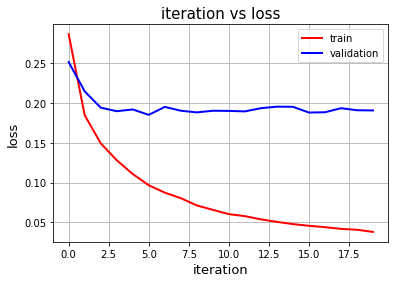

In [6]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

In [19]:
# check one caption
batch_size = 50
idx = np.random.randint(batch_size)
sample = tr_pred[idx]
words = []

# nearest neighbor searching
for i in range(20):
    best_error = float('inf')
    word_vec = sample[i]
    for word, vec in word_dict.items():
        if len(vec) == 0:
            continue
        error = np.sum(np.square(word_vec - np.array(vec)))
        if error < best_error:
            w = word
            best_error = error
    words.append(w)
    
print('Test Caption: ', ' '.join(w for w in words))

Test Caption:  <START> a small also the racers place turning but small motorcycles <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
